# Markov chain Monte Carlo (MCMC) sampling, part 1: the basics

[Markov chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is a powerful class of methods to sample from probability distributions known only up to an (unknown) normalization constant. But before we dive into MCMC, let's consider why you might want to do sampling in the first place.

The answer to that is: whenever you're either interested in the samples themselves (for example, inferring unknown parameters in Bayesian inference) or you need them to approximate expected values of functions w.r.t. to a probability distribution (for example, calculating thermodynamic quantities from the distribution of microstates in statistical physics). Sometimes, only the mode of a probability distribution is of primary interest. In this case, it's obtained by numerical optimization so full sampling is not necessary.

It turns out that sampling from any but the most basic probability distributions is a difficult task. [Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) is an elementary method to sample from probability distributions, but requires the cumulative distribution function, which in turn requires knowledge of the, generally unknown, normalization constant. Now in principle, you could just obtain the normalization constant by numerical integration, but this quickly gets infeasible with an increasing number of dimensions. [Rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling) does not require a normalized distribution, but efficiently implementing it requires a good deal of knowledge about the distribution of interest, and it suffers strongly from the curse of dimension, meaning that its efficiency decreases rapidly with an increasing number of variables. That's when you need a smart way to obtain representative samples from your distribution which doesn't require knowledge of the normalization constant.

MCMC algorithms are a class of methods which do exactly that. These methods date back to a [seminal paper by Metropolis et al.](https://pdfs.semanticscholar.org/7b3d/c9438227f747e770a6fb6d7d7c01d98725d6.pdf), who developed the first MCMC algorithm, correspondingly called [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), to calculate the equation of state of a two-dimensional system of hard spheres. In reality, they were looking for a general method to calculate expected values occurring in statistical physics.

In this blog post, I introduce the basics of MCMC sampling; in subsequent posts I'll cover several important, increasingly complex and powerful MCMC algorithms, which all address different difficulties one frequently faces when using the Metropolis-Hastings algorithm. Along the way, you will gain a solid understanding of these challenges and how to address them. Also, this serves as a reference for MCMC methods in the context of the [monad-bayes](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html) series. Furthermore, I hope the provided notebooks will not only spark your interest in exploring the behavior of MCMC algorithms for various parameters/probability distributions, but also serve as a basis for implementing and understanding useful extensions of the basic versions of the algorithms I present.

## Markov chains

Now that we know why we want to sample, let's get to the heart of MCMC &mdash; Markov chains.
What is a Markov chain?
Without all the technical details, a Markov chain is a random sequence of states in some state space in which the probability of picking a certain state next depends only on the current state in the chain and not on the previous history: it is memory-less.
Under certain conditions, a Markov chain has a unique stationary distribution of states to which it will converge after a certain number of states.
From that number on, states in the Markov chain will be distributed according to the invariant distribution.
MCMC algorithms work by constructing a Markov chain with the probability distribution you want to sample from as the stationary distribution.
In order to sample from a distribution $\pi(x)$, a MCMC algorithm constructs and simulates a Markov chain whose stationary distribution is $\pi(x)$, meaning that, after an initial "burn-in" phase, the states of that Markov chain are distributed according to $\pi(x)$. We thus just have to store the states to obtain samples from $\pi(x)$.

For didactic purposes, let's for now consider both a discrete state space and discrete "time".
The key quantity characterizing a Markov chain is the transition operator $T(x_{i+1}|x_i)$ which gives you the probability of being in state $x_{i+1}$ at time $i+1$ given that the chain is in state $x_i$ at time $i$.

Now just for fun (and for illustration), let's quickly whip up a Markov chain which has a unique stationary distribution. We'll start with some imports and settings for the plots:

In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

The Markov chain will hop around on a discrete state space which is made up from three weather states:

In [2]:
state_space = ("sunny", "cloudy", "rainy")

In a discrete state space, the transition operator is just a matrix.
Columns and rows correspond, in our case, to sunny, cloudy, and rainy weather.
We pick more or less sensible values for all transition probabilities:

In [3]:
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

The rows indicate the states the chain might currently be in and the columns the states the chains might transition to.
If we take one "time" step of the Markov chain as one hour, then, if it's sunny, there's a 60% chance it stays sunny in the next hour, a 30% chance that in the next hour we will have cloudy weather and only a 10% chance of rain immediately after it had been sunny before.
This also means that each row has to sum up to one.

Let's run our Markov chain for a while:

In [4]:
n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

We can monitor the convergence of our Markov chain to its stationary distribution by calculating the empirical probability for each of the states as a function of chain length:

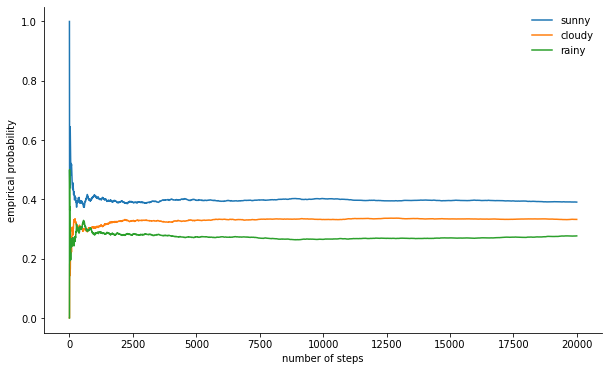

In [5]:
def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset 
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("empirical probability")
ax.legend(frameon=False)
despine(ax, ('top', 'right'))
plt.show()

## The mother of all MCMC algorithms: Metropolis-Hastings

So that's lots of fun, but back to sampling an arbitrary probability distribution $\pi$. 
It could either be discrete, in which case we would keep talking about a transition matrix $T$, or it continous, in which case $T$ would be a transition *kernel*.
From now on, we're considering continuous distributions, but all concepts presented here transfer to the discrete case.  
If we could design the transition kernel in such a way that the next state is already drawn from $\pi$, we would be done, as our Markov Chain would... well...  immediately sample from $\pi$.
Unfortunately, to do this, we need to be able to sample from $\pi$, which we can't.
Otherwise you wouldn't be reading this, right?  
A way around this is to split the transition kernel $T(x_{i+1}|x_i)$ into two parts:
a proposal step and an acceptance/rejection step. The proposal step features a proposal distribution $q(x_{i+1}|x_i)$, from which we can sample possible next states of the chain. In addition to being able to sample from it, we can choose this distribution arbitrarily. But, one should strive to design it such that samples from it are both as little correlated with the current state as possible and have a good chance of being accepted in the acceptance step. Said acceptance/rejection step is the second part of the transition kernel and corrects for the error introduced by proposal states drawn from $q \neq \pi$. It involves calculating an acceptance probability $p_\mathrm{acc}(x_{i+1}|x_i)$ and accepting the proposal $x_{i+1}$ with that probability as the next state in the chain. Drawing the next state $x_{i+1}$ from $T(x_{i+1}|x_i)$ is then done as follows: first, a proposal state $x_{i+1}$ is drawn from $q(x_{i+1}|x_i)$. It is then accepted as the next state with probability 
$p_\mathrm{acc}(x_{i+1}|x_i)$ or rejected with probability $1 - p_\mathrm{acc}(x_{i+1}|x_i)$, in which case the current state is copied as the next state.

We thus have 
$$
T(x_{i+1}|x_i)=q(x_{i+1} | x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) \ \mbox .
$$
A sufficient condition for a Markov chain to have $\pi$ as its stationary distribution is the transition kernel obeying *detailed balance* or, in the physics literature, *microscopic reversibility*:
$$
\pi(x_i) T(x_{i+1}|x_i) = \pi(x_{i+1}) T(x_i|x_{i+1})
$$
This means that the probability of being in a state $x_i$ and transitioning to $x_{i+1}$ must be equal to the probability of the reverse process, namely, being in state $x_{i+1}$ and transitioning to $x_i$.
Transition kernels of most MCMC algorithms satisfy this condition.   
For the two-part transition kernel to obey detailed balance, we need to choose $p_\mathrm{acc}$ correctly, meaning that is has to correct for any asymmetries in probability flow from / to $x_{i+1}$ or $x_i$.
One possibility is the Metropolis acceptance criterion: 
$$
p_\mathrm{acc}(x_{i+1}|x_i) = \mathrm{min} \left\{1, \frac{\pi(x_{i+1}) \times q(x_i|x_{i+1})}{\pi(x_i) \times q(x_{i+1}|x_i)} \right\} \ \mbox .
$$
Now here's where the magic happens: we know $\pi$ only up to a constant, but it doesn't matter, because that unknown constant cancels out in the expression for $p_\mathrm{acc}$! It is this property of $p_\mathrm{acc}$ which makes algorithms based on Metropolis-Hastings work for unnormalized distributions. Often, symmetric proposal distributions with $q(x_i|x_{i+1})=q(x_{i+1}|x_i)$ are used, in which case the Metropolis-Hastings algorithm reduces to the original, but less general Metropolis algorithm developed in 1953 and for which
$$
p_\mathrm{acc}(x_{i+1}|x_i) = \mathrm{min} \left\{1, \frac{\pi(x_{i+1})}{\pi(x_i)} \right\} \ \mbox .
$$
We can then write the complete Metropolis-Hastings transition kernel as
$$
T(x_{i+1}|x_i) = \begin{cases}
                   q(x_{i+1}|x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) &: x_{i+1} \neq x_i \mbox ; \\
                   1 - \int \mathrm{d}x_{i+1} \ q(x_{i+1}|x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) &: x_{i+1} = x_i\mbox .
                 \end{cases} 
$$

## Implementing the Metropolis-Hastings algorithm in Python

All right, now that we know how Metropolis-Hastings works, let's go ahead and implement it.
First, we set the log-probability of the distribution we want to sample from - without normalization constants, as we pretend we don't know them.
Let's work for now with a standard normal distribution:

In [6]:
def log_prob(x):
     return -0.5 * np.sum(x ** 2)

Next, we choose a symmetric proposal distribution.
Generally, including information you have about the distribution you want to sample from in the proposal distribution will lead to better performance of the Metropolis-Hastings algorithm. 
A naive approach is to just take the current state $x$ and pick a proposal from $\mathcal{U}(x-\frac{\Delta}{2}, x+\frac{\Delta}{2})$, that is, we set some step size $\Delta$ and move left or right a maximum of $\frac{\Delta}{2}$ from our current state:

In [7]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

Finally, we calculate our acceptance probability:

In [8]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

Now we piece all this together into our really brief implementation of a Metropolis-Hastings sampling step:

In [9]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether we accept the new state or not:
    # we draw a random number uniformly from [0,1] and compare
    # it with the acceptance probability
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

Apart from the next state in the Markov chain, `x_new` or `x_old`, we also return whether the MCMC move was accepted or not.
This will allow us to keep track of the acceptance rate.
Let's complete our implementation by writing a function that iteratively calls `sample_MH` and thus builds up the Markov chain:

In [10]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

## Testing our Metropolis-Hastings implementation and exploring its behavior

Now you're probably excited to see this in action.
Here we go, taking some informed guesses at the `stepsize` and `n_total` arguments:

In [11]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)
chain = [state for state, in chain]
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state) 
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: 0.720
Last ten states of chain: 1.05847, 1.59966, 0.14389, -1.13281, 0.24131, -0.77448, -0.59703, 0.67707, 1.47065, 1.27361


All right.
So did this work?
We achieved an acceptance rate of around 71% and we have a chain of states.
We should throw away the first few states during which the chain won't have converged to its stationary distribution yet.
Let's check whether the states we drew are actually normally distributed:

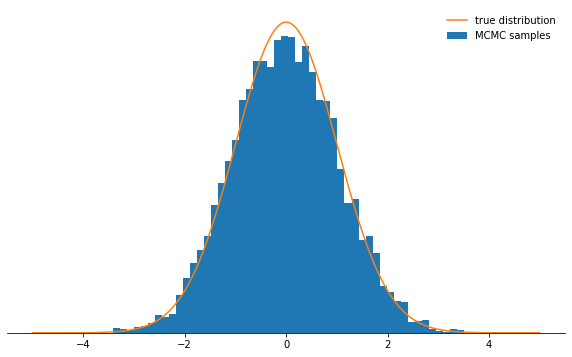

In [12]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)
    
fig, ax = plt.subplots()
plot_samples(chain[500:], log_prob, ax)
despine(ax)
ax.set_yticks(())
plt.show()

Looks great!

Now, what's up with the parameters `stepsize` and `n_total`?
We'll discuss the step size first: it determines how far away a proposal state can be from the current state of the chain. It is thus a parameter of the proposal distribution $q$ and controls how big the random steps are which the Markov chain takes. If the step size is too large, the proposal state will often be in the tails of the distribution, where probability is low.
The Metropolis-Hastings sampler rejects most of these moves, meaning that the acceptance rate decreases and convergence is much slower.
See for yourself:

Acceptance rate: 0.104


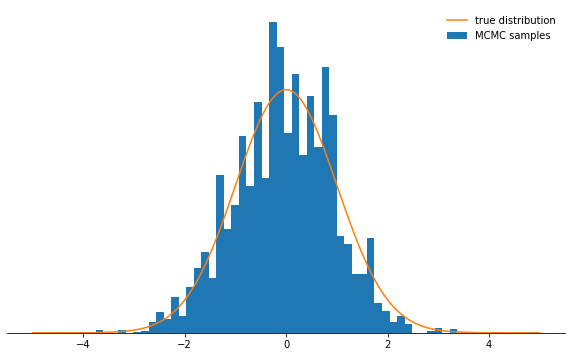

In [13]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    despine(ax)
    ax.set_yticks(())
    plt.show()
    
sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

Not as cool, right?
Now you could think the best thing to do is do choose a tiny step size.
Turns out that this is not too smart either because then the Markov chain will explore the probability distribution only very slowly and thus again won't converge as rapidly as with a well-adjusted step size:

Acceptance rate: 0.985


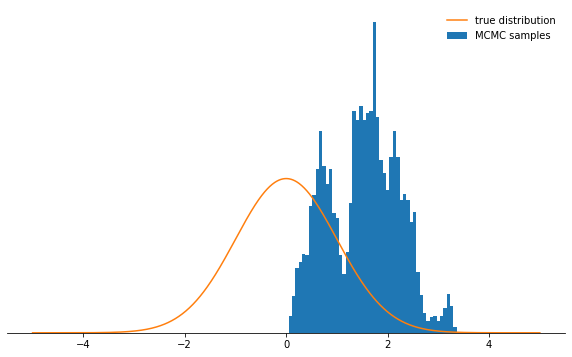

In [14]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)

No matter how you choose the step size parameter, the Markov chain will eventually converge to its stationary distribution.
But it may take a looooong time.
The time we simulate the Markov chain for is set by the `n_total` parameter - it simply determines how many states of the Markov chain (and thus samples) we'll end up with.
If the chain converges slowly, we need to increase `n_total` in order to give the Markov chain enough time to forget it's initial state.
So let's keep the tiny step size and increase the number of samples by increasing `n_total`:

Acceptance rate: 0.990


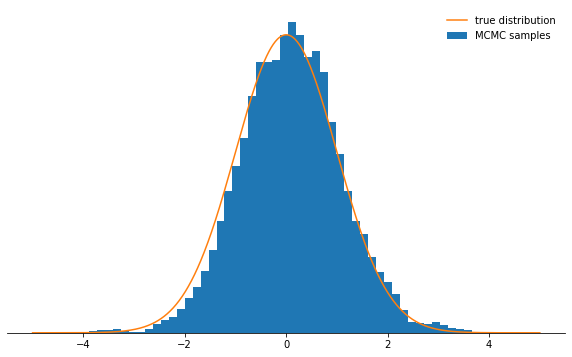

In [15]:
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)

Sloooowly getting there...

## Conclusions

With these considerations, I conclude the first blog post of this series.
I hope you now understand the intuition behind the Metropolis-Hastings algorithm, its parameters and why it is an extremely useful tool to sample from non-standard probability distributions you might encounter out there in the wild.  

I highly encourage you to play around with the code in this notebook - this way, you can learn how the algorithm behaves in various circumstances and deepen your understanding of it.
Go ahead and try out a non-symmetric proposal distribution!
What happens if you don't adjust the acceptance criterion accordingly?
What happens if you try to sample from a bimodal distribution?
Can you think of a way to automatically tune the stepsize?
What are pitfalls here?
Try out and discover yourself!  

In my next post, I will discuss the Gibbs sampler - a special case of the Metropolis-Hastings algorithm that allows you to approximately sample from a multivariate distribution by sampling from the conditional distributions.

Thanks for reading&mdash;go forward and sample!

# Introduction to MCMC, Part II: Gibbs sampling

In the [first blog post](https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html) of this series, we discussed Markov chains and the most elementary [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) method, the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), and used it to sample from a univariate distribution.
In this episode, we discuss another famous MCMC sampling algorithm: the [Gibbs sampler](https://en.wikipedia.org/wiki/Gibbs_sampling).
It is very useful to sample from multivariate distributions:
it reduces the complex problem of sampling from a joint distribution to sampling from the full conditional (meaning, conditioned on all other variables) distribution of each variable. 
That means that to sample from, say, $p(x,y)$, it is sufficient to be able to sample from $p(x|y)$ and $p(y|x)$, which might be considerably easier.
The problem of sampling from multivariate distributions often arises in Bayesian statistics, where inference of likely values for a parameter often entails sampling not only that parameter, but also additional parameters required by the statistical model.

## Motivation
Why would splitting up sampling in this way be preferable?
Well, it might turn the problem of sampling from one untractable joint distribution into sampling from several well-known, tractable distributions.
If the latter (now conditional) distributions are still not tractable, at least you now can use different and well-suited samplers for each of them instead of sampling all variables with a one-size-fits-all sampler.
Take, for example, a bivariate normal distribution with density $p(x,y)$ that has very different variances for each variable:

In [16]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

np.random.seed(42)

def log_gaussian(x, mu, sigma):
    # The np.sum() is for compatibility with sample_MH
    return - 0.5 * np.sum((x - mu) ** 2) / sigma ** 2 \
           - np.log(np.sqrt(2 * np.pi * sigma ** 2))


class BivariateNormal(object):
    n_variates = 2
    
    def __init__(self, mu1, mu2, sigma1, sigma2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2
        
    def log_p_x(self, x):
        return log_gaussian(x, self.mu1, self.sigma1)
        
    def log_p_y(self, x):
        return log_gaussian(x, self.mu2, self.sigma2)
    
    def log_prob(self, x):        
        cov_matrix = np.array([[self.sigma1 ** 2, 0],
                               [0, self.sigma2 ** 2]])
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        kernel = -0.5 * (x - self.mu1) @ inv_cov_matrix @ (x - self.mu2).T
        normalization = np.log(np.sqrt((2 * np.pi) ** self.n_variates * np.linalg.det(cov_matrix)))
        
        return kernel - normalization               

    
bivariate_normal = BivariateNormal(mu1=0.0, mu2=0.0, sigma1=1.0, sigma2=0.15)

The `@` is a recent-ish addition to Python and denotes the matrix multiplication operator.
Let's plot this density:

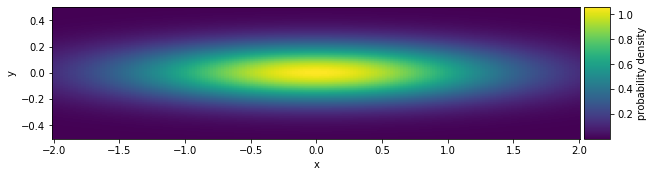

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
xses = np.linspace(-2, 2, 200)
yses = np.linspace(-0.5, 0.5, 200)
log_density_values = [[bivariate_normal.log_prob(np.array((x, y))) for x in xses] for y in yses]
dx = (xses[1] - xses[0]) / 2
dy = (yses[1] - yses[0]) / 2
extent = [xses[0] - dx, xses[-1] + dx, yses[0] - dy, yses[-1] + dy]
im = ax.imshow(np.exp(log_density_values), extent=extent)
ax.set_xlabel('x')
ax.set_ylabel('y')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax)
cb.set_label('probability density')
plt.show()

Now you can try to sample from this using the previously discussed Metropolis-Hastings algorithm with a uniform proposal distribution.
Remember that in Metropolis-Hastings, a Markov chain is built by jumping a certain distance ("step size") away from the current state, and accepting or rejecting the new state according to an acceptance probability.
A small step size will explore the possible values for \\(x\\) very slowly, while a large step size will have very poor acceptance rates for \\(y\\).
The Gibbs sampler allows us to use separate Metropolis-Hastings samplers for $x$ and $y$ - each with an appropriate step size.
Note that we could also choose a bivariate proposal distribution in the Metropolis-Hastings algorithm such that its variance in $x$-direction is larger than its variance in the $y$-direction, but let's stick to this example for didactic purposes.

##  The systematic scan Gibbs sampler 
So how does Gibbs sampling work?
The basic idea is that given the joint distribution $p(x, y)$ and a state $(x_i, y_i)$ from that distribution, you obtain a new state as follows:
first, you sample a new value for one variable, say, $x_{i+1}$, from its distribution conditioned on $y_i$, that is, from $p(x|y_i)$. Then, you sample a new state for the second variable, $y_{i+1}$, from its distribution conditioned on the previously drawn state for $x$, that is, from $p(y|x_{i+1})$.
This two-step procedure can be summarized as follows: 
$$
\begin{align} x_{i+1} \sim& \ p(x|y_i) \\
              y_{i+1} \sim& \ p(y|x_{i+1})
\end{align}
$$
This is then iterated to build up the Markov chain.
For more than two variables, the procedure is analogous: you pick a fixed ordering and draw one variable after the other, each conditioned on, in general, a mix of old and new values for all other variables.[^1]
Fixing an ordering, like this, is called a _systematic scan_, an alternative is the _random scan_ where we'd randomly pick a new ordering at each iteration.

Implementing this Gibbs sampler for the above example is extremely simple, because the two variables are independent ($p(x|y)=p(x)$ and $p(y|x)=p(y)$).
We sample each of them with a Metropolis-Hastings sampler, implemented in the <a href="https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html">first blog post</a> as the `sample_MH` function.
As a reminder, that function takes as arguments, in that order,
- the old state of a Markov chain (a one-dimensional `numpy` array),
- a function returning the logarithm of the probability density function (PDF) to sample from, 
- a real number representing the step size for the uniform proposal distribution, from which a new state is proposed. 

We then use `sample_MH` in the following, short function which implements the systematic scan Gibbs sampler:

In [18]:
def sample_gibbs(old_state, bivariate_dist, stepsizes):
    """Draws a single sample using the systematic Gibbs sampling
    transition kernel
    
    Arguments:
    - old_state: the old (two-dimensional) state of a Markov chain
                 (a list containing two floats)
    - bivariate_dist: an object representing a bivariate distribution
                      (in our case, an instance of BivariateNormal)
    - stepsizes: a list of step sizes
    
    """
    x_old, y_old = old_state
    
    # for compatibility with sample_MH, change floats to one-dimensional
    # numpy arrays of length one
    x_old = np.array([x_old])
    y_old = np.array([y_old])
    
    # draw new x conditioned on y
    p_x_y = bivariate_dist.log_p_x
    accept_x, x_new = sample_MH(x_old, p_x_y, stepsizes[0])
    
    # draw new y conditioned on x
    p_y_x = bivariate_dist.log_p_y
    accept_y, y_new = sample_MH(y_old, p_y_x, stepsizes[1])
    
    # Don't forget to turn the one-dimensional numpy arrays x_new, y_new
    # of length one back into floats
    
    return (accept_x, accept_y), (x_new[0], y_new[0])

The `sample_gibbs` function will yield one single sample from `bivariate_normal`.
As we did in the previous blog post for the Metropolis-Hastings algorithm, we now write a function that repeatedly runs `sample_gibbs` to build up a Markov chain and call it:

In [19]:
def build_gibbs_chain(init, stepsizes, n_total, bivariate_dist):
    """Builds a Markov chain by performing repeated transitions using
    the systematic Gibbs sampling transition kernel
    
    Arguments:
    - init: an initial (two-dimensional) state for the Markov chain
            (a list containing two floats)
    - stepsizes: a list of step sizes of type float
    - n_total: the total length of the Markov chain
    - bivariate_dist: an object representing a bivariate distribution
                      (in our case, an instance of BivariateNormal)
    
    """
    init_x, init_k = init
    chain = [init]
    acceptances = []
    
    for _ in range(n_total):
        accept, new_state = sample_gibbs(chain[-1], bivariate_dist, stepsizes)
        chain.append(new_state)        
        acceptances.append(accept)
    
    acceptance_rates = np.mean(acceptances, 0)
    print("Acceptance rates: x: {:.3f}, y: {:.3f}".format(acceptance_rates[0],
                                                          acceptance_rates[1]))
    
    return chain 

stepsizes = (6.5, 1.0)
initial_state = [2.0, -1.0]
chain = build_gibbs_chain(initial_state, stepsizes, 100000, bivariate_normal)
chain = np.array(chain)

Acceptance rates: x: 0.462, y: 0.456


Tada! 
We used two very different step sizes and achieved very similar acceptance rates with both.  
We now plot a 2D histogram of the samples (with the estimated probability density color-coded) and the marginal distributions:

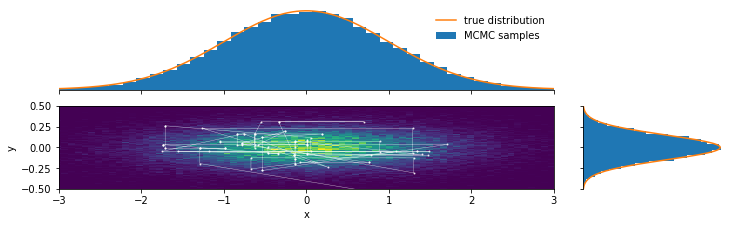

In [20]:
def plot_samples_2D(chain, path_length, burnin, ax, lims=(-5, 5)):
    chain = np.array(chain)
    bins = np.linspace(lims[0], lims[1], 100)
    ax.hist2d(*chain[burnin:].T, bins=100)
    ax.plot(*chain[:path_length].T, marker='o', c='w', lw=0.4, 
            markersize=1, alpha=0.75)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-3,3)
    ax.set_ylim(-0.5, 0.5)
    
def plot_bivariate_samples(chain, burnin, pdf):
    fig = plt.figure(figsize=(12,7))
   
    ax_c = plt.subplot2grid((4, 4), (1, 0), rowspan=1, colspan=3)
    plot_samples_2D(chain, 100, burnin, ax_c)
    
    ax_t = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3, sharex=ax_c)
    plot_samples(chain[:,0], pdf.log_p_x, ax_t, normalize=False)
    plt.setp(ax_t.get_xticklabels(), visible=False)
    ax_t.set_yticks(())
    for spine in ('top', 'left', 'right'):
        ax_t.spines[spine].set_visible(False)

    ax_r = plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1, sharey=ax_c)
    plot_samples(chain[:,1], pdf.log_p_y, ax_r, orientation='horizontal',
                 normalize=False, legend=False)
    plt.setp(ax_r.get_yticklabels(), visible=False)
    ax_r.set_xticks(())
    for spine in ('top', 'bottom', 'right'):
        ax_r.spines[spine].set_visible(False)

    plt.show()
    
plot_bivariate_samples(chain, burnin=200, pdf=bivariate_normal)

Looking at the path the Markov chain takes, we see several horizontal and vertical lines.
These are Gibbs sampling steps in which only one of the Metropolis-Hastings moves was accepted.

## A more complex example
The previous example was rather trivial in the sense that both variables were independent.
Let's discuss a more interesting example, which features both a discrete and a continuous variable.
We consider a mixture of two normal densities $p_\mathcal{N}(x; \mu, \sigma)$ with relative weights $w_1$ and $w_2$.
The PDF we want to sample from is then
$$
p(x) = w_1p_\mathcal{N}(x; \mu_1, \sigma_1) + w_2p_\mathcal{N}(x; \mu_2, \sigma_2) \ \mbox .
$$
This probability density is just a weighted sum of normal densities.
Let's consider a concrete example, choosing the following mixture parameters:

In [21]:
mix_params = dict(mu1=1.0, mu2=2.0, sigma1=0.5, sigma2=0.2, w1=0.3, w2=0.7)

How does it look like?
Well, it's a superposition of two normal distributions:

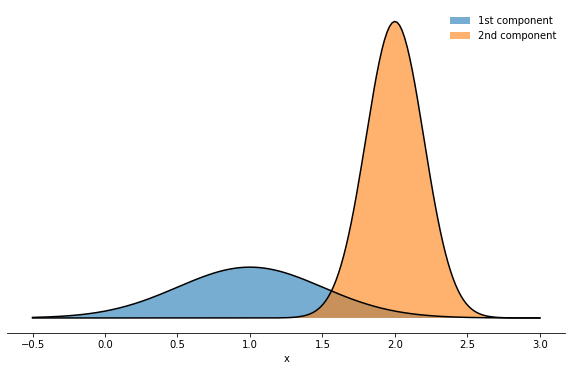

In [22]:
fig, ax = plt.subplots()
xspace = np.linspace(-0.5, 3, 200)

# densities of both components
first_component = [np.exp(log_gaussian(x, mix_params['mu1'], mix_params['sigma1']))
                   for x in xspace]
second_component = [np.exp(log_gaussian(x, mix_params['mu2'], mix_params['sigma2']))
                    for x in xspace]

# apply component weights
first_component = mix_params['w1'] * np.array(first_component)
second_component = mix_params['w2'] * np.array(second_component)

ax.plot(xspace, first_component, color='black')
ax.fill_between(xspace, first_component, alpha=0.6, label="1st component")
ax.plot(xspace, second_component, color='black')
ax.fill_between(xspace, second_component, alpha=0.6, label="2nd component")
ax.set_xlabel('x')
ax.set_yticks(())
ax.legend(frameon=False)
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
plt.show()

Inspired by this figure, we can also make the mixture nature of that density more explicit by introducing an additional integer variable $ k \in \{1,2\} $ which enumerates the mixture components.
This will allow us to highlight several features and properties of the Gibbs sampler and to introduce an important term in probability theory along the way.
Having introduced a second variable means that we can consider several probability distributions: 

- $p(x,k)$: the joint distribution of $x$ and $k$ tells us how probable it is to find a value for $x$ and a value for $k$ "at the same time" and is given by
$$
p(x|k) = w_kp_\mathcal{N}(x; \mu_k, \sigma_k \ \mbox .
$$
- $p(x|k)$: the conditional distribution of $x$ given $k$ tells us the probability of $x$ for a certain $k$. For example, if $k=1$, what is $p(x|k)$? Setting $k=1$ means we're considering only the first mixture component, which is a normal distribution with mean $\mu_1$ and standard deviation $\sigma_1$ and thus $p(x|k=1)=p_\mathcal{N}(x; \mu_1, \sigma_1)$. In general we then have
$$
p(x|k) = p_\mathcal{N}(x; \mu_k, \sigma_k) \ \mbox .
$$
- $p(k|x)$: assuming a certain value $x$, this probability distribution tells us for each $k$ the probability with which you would draw $x$ from the mixture component with index $k$. This probability is non-trivial, as the mixture components overlap and each $x$ thus has a non-zero probability in each component. But [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) saves us and yields
$$
p(k|x) = \frac{p(x|k) p(k)}{p(x)} \ \mbox .
$$
- $p(k)$: this is the probability of choosing a mixture component $k$ irrespective of $x$ and is given by the mixture weights $w_k$.

The probability distributions $p(x)$ and $p(k)$ are related to the joint distribution $p(x,k)$ by a procedure called [*marginalization*](https://en.wikipedia.org/wiki/Marginal_distribution).
We marginalize $p(x,k)$ over, say, $k$, when we are only interested in the probability of $x$, independent of a specific value for $k$.
That means that the probability of $x$ is the sum of the probability of $x$ when $k=1$ plus the probability of $x$ when $k=2$, or, formally,
$$
p(x)=\sum_{ k \in \{1, 2\} } p(x,k) \ \mbox .
$$

With these probability distributions, we have all the required ingredients for setting up a Gibbs sampler.
We can then sample from $p(x,k)$ and reconstruct $p(x)$ by marginalization.
As marginalization means "not looking a variable", obtaining samples from $p(x)$ given samples from $p(x,k)$ just amounts to discarding the sampled values for $k$.

Let's first implement a Gaussian mixture with these conditional distributions:

In [23]:
class GaussianMixture(object):
    
    def __init__(self, mu1, mu2, sigma1, sigma2, w1, w2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2
        self.w1, self.w2 = w1, w2
        
    def log_prob(self, x):
        return np.logaddexp(np.log(self.w1) + log_gaussian(x, self.mu1, self.sigma1),
                            np.log(self.w2) + log_gaussian(x, self.mu2, self.sigma2))
    
    def log_p_x_k(self, x, k):
        # logarithm of p(x|k)
        mu = (self.mu1, self.mu2)[k]
        sigma = (self.sigma1, self.sigma2)[k]
    
        return log_gaussian(x, mu, sigma)
    
    def p_k_x(self, k, x):
        # p(k|x) using Bayes' theorem
        mu = (self.mu1, self.mu2)[k]
        sigma = (self.sigma1, self.sigma2)[k]
        weight = (self.w1, self.w2)[k]
        log_normalization = self.log_prob(x)

        return np.exp(log_gaussian(x, mu, sigma) + np.log(weight) - log_normalization)

The interesting point here (and, in fact, the reason I chose this example) is that $p(x|k)$ is a probability density for a *continuous* variable $x$, while $p(k|x)$ is a probability distribution for a *discrete* variable. This means we will have to choose two very different sampling methods.
While we could just use a built-in `numpy` function to draw from the normal distributions $p(x|k)$, we will use Metropolis-Hastings.
The freedom to do this really demonstrates the flexibility we have in choosing samplers for the conditional distributions.

So we need to reimplement `sample_gibbs` and `build_gibbs_chain`, whose arguments are very similar to the previous implementation, but with a slight difference: the states now consist of a float for the continuous variabe and an integer for the mixture component, and instead of a list of stepsizes we just need one single stepsize, as we have only one variable to be sampled with Metropolis-Hastings.

In [24]:
def sample_gibbs(old_state, mixture, stepsize):
    """Draws a single sample using the systematic Gibbs sampling
    transition kernel
    
    Arguments:
    - old_state: the old (two-dimensional) state of a Markov chain
                 (a list containing a float and an integer representing 
                 the initial mixture component)
    - mixture: an object representing a mixture of densities
               (in our case, an instance of GaussianMixture)
    - stepsize: a step size of type float 
    
    """
    x_old, k_old = old_state
    
    # for compatibility with sample_MH, change floats to one-dimensional
    # numpy arrays of length one
    x_old = np.array([x_old])
    
    # draw new x conditioned on k
    x_pdf = lambda x: mixture.log_p_x_k(x, k_old)
    accept, x_new = sample_MH(x_old, x_pdf, stepsize)
    
    # ... turn the one-dimensional numpy arrays of length one back
    # into floats
    x_new = x_new[0]
    
    # draw new k conditioned on x 
    k_probabilities = (mixture.p_k_x(0, x_new), mixture.p_k_x(1, x_new))
    jump_probability = k_probabilities[1 - k_old]
    k_new = np.random.choice((0,1), p=k_probabilities)
    
    return accept, jump_probability, (x_new, k_new)


def build_gibbs_chain(init, stepsize, n_total, mixture):
    """Builds a Markov chain by performing repeated transitions using
    the systematic Gibbs sampling transition kernel
    
    Arguments:
    - init: an initial (two-dimensional) state of a Markov chain
            (a list containing a one-dimensional numpy array
            of length one and an integer representing the initial
            mixture component)
    - stepsize: a step size of type float
    - n_total: the total length of the Markov chain
    - mixture: an object representing a mixture of densities
               (in our case, an instance of GaussianMixture)
    
    """
    init_x, init_k = init
    chain = [init]
    acceptances = []
    jump_probabilities = []
    
    for _ in range(n_total):
        accept, jump_probability, new_state = sample_gibbs(chain[-1], mixture, stepsize)
        chain.append(new_state)
        jump_probabilities.append(jump_probability)
        acceptances.append(accept)
    
    acceptance_rates = np.mean(acceptances)
    print("Acceptance rate: x: {:.3f}".format(acceptance_rates))
    print("Average probability to change mode: {}".format(np.mean(jump_probabilities)))
    
    return chain

mixture = GaussianMixture(**mix_params)
stepsize = 1.0
initial_state = [2.0, 1]
chain = build_gibbs_chain(initial_state, stepsize, 10000, mixture)
burnin = 1000
x_states = [state[0] for state in chain[burnin:]]

Acceptance rate: x: 0.631
Average probability to change mode: 0.08629295966662387


Plotting a histogram of our samples shows that the Gibbs sampler correctly reproduces the desired Gaussian mixture: 

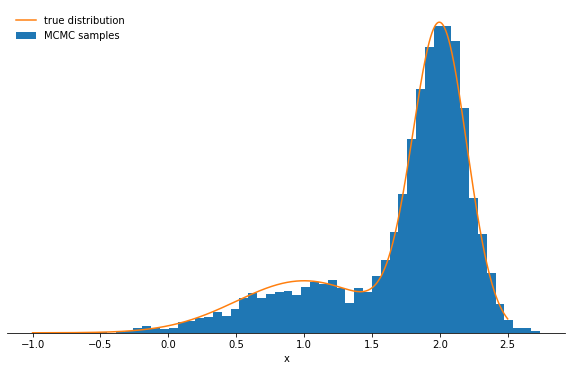

In [25]:
fig, ax = plt.subplots()
plot_samples(x_states, mixture.log_prob, ax, normalize=False, xlims=(-1,2.5))
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
ax.set_yticks(())
ax.set_xlabel('x')
plt.show()

You might wonder why we're also printing the average probability for the chain to sample from the component it is currently *not* in.
If this probability is very low, the Markov chain will get stuck for some time in the current mode and thus will have difficulties exploring the distribution rapidly. 
The quantity of interest here is $p(k|x)$: 
it is the probability of a certain component $k$ given a certain value $x$ and can be very low if the components are more separated and $x$ is more likely to be in the component which is not $k$. 
Let's explore this behavior by increasing the separation between the means of the mixture components:

In [26]:
mixture = GaussianMixture(mu1=-1.0, mu2=2.0, sigma1=0.5, sigma2=0.2, w1=0.3, w2=0.7)
stepsize = 1.0
initial_state = [2.0, 1]
chain = build_gibbs_chain(initial_state, stepsize, 100000, mixture)
burnin = 10000
x_states = [state[0] for state in chain[burnin:]]

Acceptance rate: x: 0.558
Average probability to change mode: 6.139534006013391e-06


Let's plot the samples and the true distribution and see how the Gibbs sampler performs in this case:

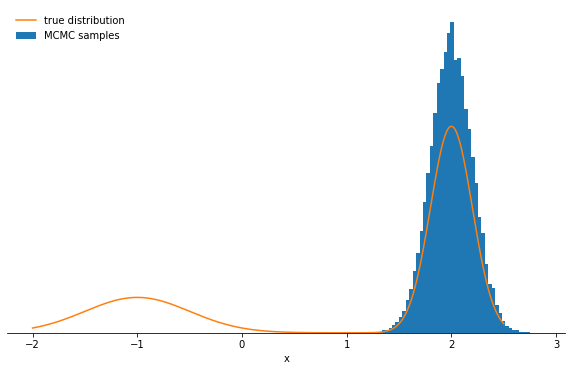

In [27]:
fig, ax = plt.subplots()
plot_samples(x_states, mixture.log_prob, ax, normalize=False, xlims=(-2,2.5))
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
ax.set_yticks(())
ax.set_xlabel('x')
plt.show()

You should see the probability decrease significantly and perhaps one of the modes being strongly over- and the other undersampled. 
The lesson here is that the Gibbs sampler might produce highly correlated samples.
Again&mdash;in the limit of many, many samples&mdash;the Gibbs sampler will reproduce the correct distribution, but you might have to wait a long time.

## Conclusions
By now, I hope you have a basic understanding of why Gibbs sampling is an important MCMC technique, how it works and why it can produce highly correlated samples.
I encourage you again to download the <a href="https://github.com/tweag/blog-resources/blob/master/mcmc-intro/mcmc_introduction.ipynb">full notebook</a> and play around with the code:
you could try using the `normal` function from the `numpy.random` module instead of Metropolis-Hastings in both examples or implement a *random* scan, in which the order in which you sample from the conditional distributions is chosen randomly. 

Or you could read about and implement the <a href="https://en.wikipedia.org/wiki/Gibbs_sampling#Collapsed_Gibbs_sampler">collapsed Gibbs sampler</a>, which allows you to perfectly sample the Gaussian mixture example by sampling from $p(k)$ instead of $p(k|x)$. 
Or you can just wait a little more for the next post in the series, which will be about Hybrid Monte Carlo (HMC), 
a fancy Metropolis-Hastings variant which takes into account the derivative of the log-probability of interest to propose better, less correlated, states!

<hline>

1. It's important to note, though, that the transition kernel given py the above procedure does _not_ define a detailed-balanced transition kernel for a Markov chain on the joint space of $x$ and $y$. One can show, though, that for each single variable, this procedure is a detailed-balanced transition kernel and the Gibbs sampler thus constitutes a composition of Metropolis-Hastings steps with acceptance probability 1. For details, see, for example, [this stats.stackexchange.com answer](https://stats.stackexchange.com/a/118453).